In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [55]:
df = pd.read_csv('./sample_data/cafe_sales.csv')

In [56]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


### Visualization

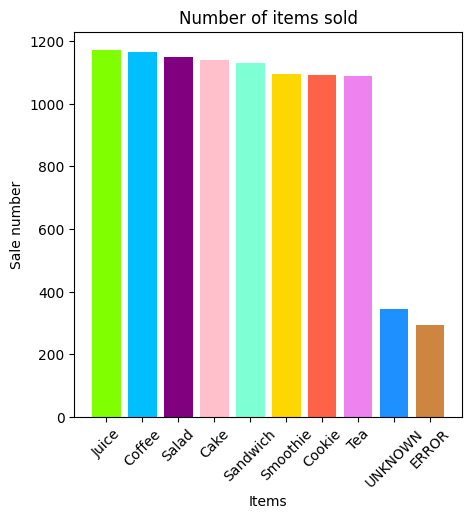

In [57]:
brand_counts = df['Item'].value_counts()
bar_colors = ['chartreuse', 'deepskyblue','purple','pink','aquamarine','gold','tomato','violet','dodgerblue','peru']

plt.figure(figsize=(5, 5))
plt.bar(brand_counts.index, brand_counts.values, color=bar_colors)
plt.title("Number of items sold")
plt.xlabel("Items")
plt.ylabel("Sale number")
plt.xticks(rotation=45)
plt.show()

***This bar chart illustrates the total of sale number per item***

In [58]:
payment_methods = df['Payment Method'].value_counts()
labels = payment_methods.index
sizes = payment_methods.values

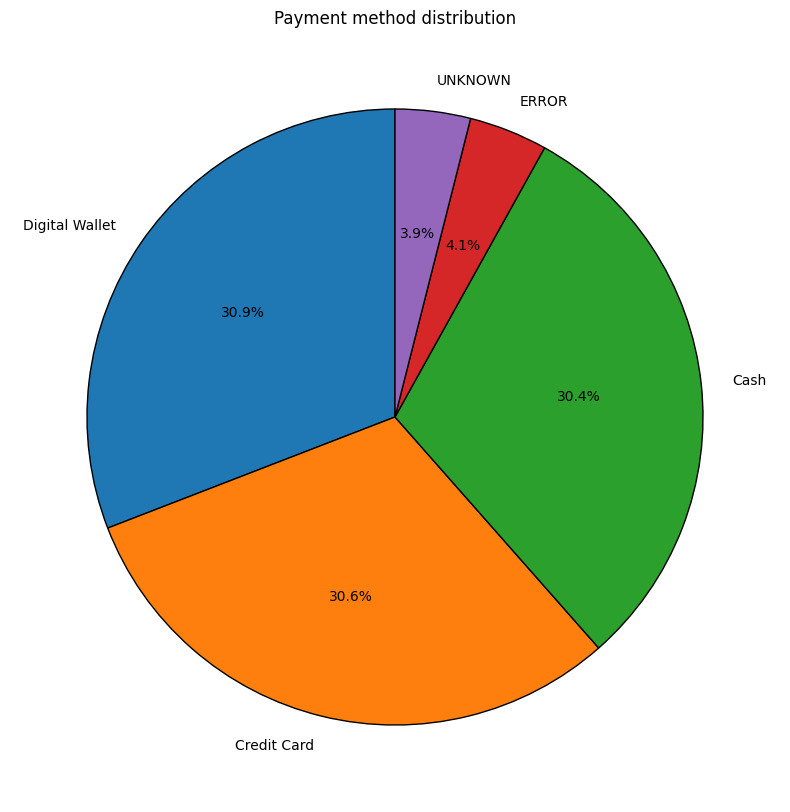

In [59]:
plt.figure(figsize=(10,10))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Payment method distribution")
plt.show()

***This is a pie chart shows which payment methods was used the most.***

-----------------

#### Number of missing values

In [60]:
df.isna().sum()

,0
Transaction ID,0
Item,333
Quantity,138
Price Per Unit,179
Total Spent,173
Payment Method,2579
Location,3265
Transaction Date,159


### Handling Missing values


> - For ***Location*** and ***Payment Method***, we replace them with most frequent value
> - For ***Item*** we can try to replace using **Price per Unit**
> - For ***Quantity*** we can try to replace by dividing **Total Spent** by **Price per Unit**
> - For ***Price per Unit*** we can try to replace dividing **Total Spent** by **Quantity**
> - For ***Total Spent*** we can try to replace multiply **Quantity** and **Price per Unit**

#### Inital values in **Payment Method**

In [61]:
df['Payment Method'].unique()

array(['Credit Card', 'Cash', 'UNKNOWN', 'Digital Wallet', 'ERROR', nan],
      dtype=object)

#### Inital values in **Location**

In [62]:
df['Location'].unique()

array(['Takeaway', 'In-store', 'UNKNOWN', nan, 'ERROR'], dtype=object)

#### Changing all UNKNOWN and ERROR to NaN in ***Payment Method*** and ***Location***

In [63]:
# Replace 'UNKNOWN' and 'ERROR' with NaN
df['Location'] = df['Location'].replace(['UNKNOWN', 'ERROR'], np.nan)
df['Payment Method'] = df['Payment Method'].replace(['UNKNOWN', 'ERROR'], np.nan)

In [64]:
df['Payment Method'].unique()

array(['Credit Card', 'Cash', nan, 'Digital Wallet'], dtype=object)

In [65]:
df['Location'].unique()

array(['Takeaway', 'In-store', nan], dtype=object)

#### Replacing NaN with default value 'Unknown' because
> - It avoids making assumptions about missing data.
> - It clearly indicates that the value was missing rather than inferred.
> - It ensures consistency in our dataset without distorting actual distributions.

In [66]:
df['Location'] = df['Location'].fillna('Unknown')

In [67]:
df['Payment Method'] = df['Payment Method'].fillna('Unknown')

### Replacing the 'Unknown' with most frequent data in 'Payment Method' Column

In [68]:
most_frequent = df.loc[df['Payment Method'] != 'Unknown', 'Payment Method'].mode()[0]
df['Payment Method'] = df['Payment Method'].replace('Unknown', most_frequent)

### Replacing the 'Unknown' with most frequent data in 'Location' Column

In [69]:
most_frequent_location = df.loc[df['Location'] != 'Unknown', 'Location'].mode()[0]
df['Location'] = df['Location'].replace('Unknown', most_frequent_location)

------------

#### Drop all NaN rows based on ***Transaction Date***

In [70]:
# Replace 'UNKNOWN' and 'ERROR' with NaN
df['Transaction Date'] = df['Transaction Date'].replace(['UNKNOWN', 'ERROR'], np.nan)

In [71]:
df.dropna(subset=['Transaction Date'], inplace=True)

### Let's change all 'UNKNOWN' and 'ERROR' to NaN

In [72]:
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')

### Filling out ***Total Spent*** by ***[ Total Spent = quantity * price per unit]***

In [73]:
# Fill 'Total Spent' where both 'Quantity' and 'Price Per Unit' are not NaN
df['Total Spent'] = df.apply(
    lambda row: row['Quantity'] * row['Price Per Unit']
    if pd.notna(row['Quantity']) and pd.notna(row['Price Per Unit'])
    else row['Total Spent'],
    axis=1
)

### Filling out ***Price per Unit*** by [ Price per Unit = Total Spent/Quantity]

In [74]:
# Fill 'Price Per Unit' where 'Total Spent' is available but 'Price Per Unit' is NaN
df['Price Per Unit'] = df.apply(
    lambda row: row['Total Spent'] / row['Quantity']
    if pd.notna(row['Total Spent']) and pd.isna(row['Price Per Unit'])
    else row['Price Per Unit'],
    axis=1
)

### Filling out ***Quantity*** by ***[ Quantity = Total Spent/Price per Unit]***

In [75]:
# Fill 'Quantity' where 'Total Spent' is available but 'Quantity' is NaN
df['Quantity'] = df.apply(
    lambda row: row['Total Spent'] / row['Price Per Unit']
    if pd.notna(row['Total Spent']) and pd.isna(row['Quantity'])
    else row['Quantity'],
    axis=1
)

### There is still NaN values in ***Price Per Unit***. We can replace them by making a dictionary of item prices and replacing them

In [76]:
item_prices = {
    'Cookie': 1.0,
    'Tea': 1.5,
    'Coffee': 2.0,
    'Cake': 3.0,
    'Juice':3.0,
    'Sandwich': 4.0,
    'Smoothie':4.0,
    'Salad': 5.0
}

In [77]:
# Fill 'Price Per Unit' using the item_prices dictionary where it is NaN
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Item'].map(item_prices))

### Now, let's re-run formula to calculate ***Total Spent***

In [78]:
# Fill 'Total Spent' where both 'Quantity' and 'Price Per Unit' are not NaN
df['Total Spent'] = df.apply(
    lambda row: row['Quantity'] * row['Price Per Unit']
    if pd.notna(row['Quantity']) and pd.notna(row['Price Per Unit'])
    else row['Total Spent'],
    axis=1
)

### Now, let's re-run formula to calculate ***Quantity***

In [79]:
# Fill 'Quantity' where 'Total Spent' is available but 'Quantity' is NaN
df['Quantity'] = df.apply(
    lambda row: row['Total Spent'] / row['Price Per Unit']
    if pd.notna(row['Total Spent']) and pd.isna(row['Quantity'])
    else row['Quantity'],
    axis=1
)

-----------------

### Now let's tackle ***Item*** column

In [80]:
df['Item'].unique()

array(['Coffee', 'Cake', 'Cookie', 'Salad', 'Smoothie', 'UNKNOWN',
       'Sandwich', nan, 'ERROR', 'Juice', 'Tea'], dtype=object)

In [81]:
df['Item'] = df['Item'].replace(['UNKNOWN', 'ERROR'], np.nan)

In [82]:
df['Item'].unique()

array(['Coffee', 'Cake', 'Cookie', 'Salad', 'Smoothie', nan, 'Sandwich',
       'Juice', 'Tea'], dtype=object)

In [83]:
item_pricez = {
    'Cookie': 1.0,
    'Tea': 1.5,
    'Coffee': 2.0,
    'Salad': 5.0
}

In [84]:
# Fill NaN values in 'Item' using 'Price Per Unit' mapped to item_prices dictionary
reverse_price_map = {price: item for item, price in item_pricez.items()}

In [85]:
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(reverse_price_map))

### Now let's drop rows based on ***Total Spent***

In [86]:
df = df.dropna(subset=['Total Spent'])

### Now let's drop rows based on ***Quantity***

In [87]:
df = df.dropna(subset=['Quantity'])

### Replacing NaN values in ***Item***

> Instead of randoming assigning Item Names, we will just keep them as Unknowns

In [88]:
df['Item'] = df['Item'].fillna('UNKNOWN')

In [89]:
nan_rows = df[df['Item'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [Transaction ID, Item, Quantity, Price Per Unit, Total Spent, Payment Method, Location, Transaction Date]
Index: []


In [90]:
df.isna().sum()

,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


In [91]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,Digital Wallet,Takeaway,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11


#### Outlier Detection and Removal

In [92]:
# Step 1: Calculate Q1, Q3, and IQR
Q1 = df['Total Spent'].quantile(0.25)
Q3 = df['Total Spent'].quantile(0.75)
IQR = Q3 - Q1

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)

# Step 2: Determine the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\nLower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Step 3: Identify outliers
outliers = df[(df['Total Spent'] < lower_bound) | (df['Total Spent'] > upper_bound)]

# Step 4: Handle outliers (remove them in this example)
data_cleaned = df[(df['Total Spent'] >= lower_bound) & (df['Total Spent'] <= upper_bound)]

Q1: 4.0
Q3: 12.0
IQR: 8.0

Lower Bound: -8.0
Upper Bound: 24.0


In [93]:
outliers

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
10,TXN_2548360,Salad,5.0,5.0,25.0,Cash,Takeaway,2023-11-07
51,TXN_6342161,Salad,5.0,5.0,25.0,Digital Wallet,Takeaway,2023-01-08
52,TXN_8914892,Salad,5.0,5.0,25.0,Digital Wallet,Takeaway,2023-03-15
96,TXN_5220895,Salad,5.0,5.0,25.0,Cash,In-store,2023-06-10
100,TXN_9517146,Salad,5.0,5.0,25.0,Cash,Takeaway,2023-10-30
...,...,...,...,...,...,...,...,...
9791,TXN_1232346,Salad,5.0,5.0,25.0,Digital Wallet,In-store,2023-01-04
9805,TXN_9506076,Salad,5.0,5.0,25.0,Digital Wallet,Takeaway,2023-01-17
9879,TXN_6393305,Salad,5.0,5.0,25.0,Digital Wallet,In-store,2023-10-19
9908,TXN_8922585,Salad,5.0,5.0,25.0,Credit Card,Takeaway,2023-06-22


In [94]:
data_cleaned

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,Digital Wallet,Takeaway,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
...,...,...,...,...,...,...,...,...
9995,TXN_7672686,Coffee,2.0,2.0,4.0,Digital Wallet,Takeaway,2023-08-30
9996,TXN_9659401,Cookie,3.0,1.0,3.0,Digital Wallet,Takeaway,2023-06-02
9997,TXN_5255387,Coffee,4.0,2.0,8.0,Digital Wallet,Takeaway,2023-03-02
9998,TXN_7695629,Cookie,3.0,1.0,3.0,Digital Wallet,Takeaway,2023-12-02


### Data Reduction

In [95]:
sampled_data = df.sample(frac=0.3, random_state=42)

In [96]:
sampled_data

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
4435,TXN_5108439,Salad,2.0,5.0,10.0,Digital Wallet,In-store,2023-05-06
4929,TXN_6216278,Coffee,4.0,2.0,8.0,Credit Card,In-store,2023-11-06
7007,TXN_2844982,Cookie,1.0,1.0,1.0,Digital Wallet,Takeaway,2023-03-04
4965,TXN_3484276,Cookie,5.0,1.0,5.0,Digital Wallet,Takeaway,2023-06-14
9759,TXN_7641606,Coffee,3.0,2.0,6.0,Credit Card,Takeaway,2023-12-26
...,...,...,...,...,...,...,...,...
1201,TXN_3121271,Smoothie,2.0,4.0,8.0,Credit Card,Takeaway,2023-08-13
8915,TXN_4298189,Coffee,1.0,2.0,2.0,Digital Wallet,In-store,2023-10-13
9048,TXN_4789941,Sandwich,3.0,4.0,12.0,Credit Card,Takeaway,2023-04-17
2330,TXN_3849488,Salad,1.0,5.0,5.0,Digital Wallet,In-store,2023-03-01


In [97]:
reduced_data = sampled_data.drop(columns=['Transaction ID'])

In [98]:
reduced_data

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
4435,Salad,2.0,5.0,10.0,Digital Wallet,In-store,2023-05-06
4929,Coffee,4.0,2.0,8.0,Credit Card,In-store,2023-11-06
7007,Cookie,1.0,1.0,1.0,Digital Wallet,Takeaway,2023-03-04
4965,Cookie,5.0,1.0,5.0,Digital Wallet,Takeaway,2023-06-14
9759,Coffee,3.0,2.0,6.0,Credit Card,Takeaway,2023-12-26
...,...,...,...,...,...,...,...
1201,Smoothie,2.0,4.0,8.0,Credit Card,Takeaway,2023-08-13
8915,Coffee,1.0,2.0,2.0,Digital Wallet,In-store,2023-10-13
9048,Sandwich,3.0,4.0,12.0,Credit Card,Takeaway,2023-04-17
2330,Salad,1.0,5.0,5.0,Digital Wallet,In-store,2023-03-01


In [99]:
scaler = MinMaxScaler()
reduced_data[['Price Per Unit_Scaled', 'Total Spent_Scaled']] = scaler.fit_transform(reduced_data[['Price Per Unit', 'Total Spent']])

In [100]:
reduced_data['Price_Category'] = pd.cut(
    reduced_data['Price Per Unit'],
    bins=[0, 20, 50, 100],
    labels=['Low', 'Medium', 'High']
)

In [101]:
reduced_data[['Price Per Unit', 'Total Spent', 'Price Per Unit_Scaled', 'Total Spent_Scaled', 'Price_Category']]

,Price Per Unit,Total Spent,Price Per Unit_Scaled,Total Spent_Scaled,Price_Category
4435,5.0,10.0,1.00,0.375000,Low
4929,2.0,8.0,0.25,0.291667,Low
7007,1.0,1.0,0.00,0.000000,Low
4965,1.0,5.0,0.00,0.166667,Low
9759,2.0,6.0,0.25,0.208333,Low
...,...,...,...,...,...
1201,4.0,8.0,0.75,0.291667,Low
8915,2.0,2.0,0.25,0.041667,Low
9048,4.0,12.0,0.75,0.458333,Low
2330,5.0,5.0,1.00,0.166667,Low


## General Overview of Data

In [102]:
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2854 entries, 4435 to 6739
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Item                   2854 non-null   object  
 1   Quantity               2854 non-null   float64 
 2   Price Per Unit         2854 non-null   float64 
 3   Total Spent            2854 non-null   float64 
 4   Payment Method         2854 non-null   object  
 5   Location               2854 non-null   object  
 6   Transaction Date       2854 non-null   object  
 7   Price Per Unit_Scaled  2854 non-null   float64 
 8   Total Spent_Scaled     2854 non-null   float64 
 9   Price_Category         2854 non-null   category
dtypes: category(1), float64(5), object(4)
memory usage: 290.4+ KB


In [103]:
reduced_data.describe()

,Quantity,Price Per Unit,Total Spent,Price Per Unit_Scaled,Total Spent_Scaled
count,2854.000000,2854.000000,2854.000000,2854.000000,2854.000000
mean,3.056762,2.950596,9.033111,0.487649,0.334713
std,1.406859,1.274330,6.017023,0.318582,0.250709
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.000000,4.000000,0.250000,0.125000
50%,3.000000,3.000000,8.000000,0.500000,0.291667
75%,4.000000,4.000000,12.000000,0.750000,0.458333
max,5.000000,5.000000,25.000000,1.000000,1.000000


# Dispersion Measures:


In [105]:
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

stats = {}

for col in numeric_cols:
    data = df[col]
    stats[col] = {
        'Range': data.max() - data.min(),
        'Q1': data.quantile(0.25),
        'Median (Q2)': data.median(),
        'Q3': data.quantile(0.75),
        'IQR': data.quantile(0.75) - data.quantile(0.25),
        'Variance': data.var(),
        'Standard Deviation': data.std()
    }

pd.DataFrame(stats).T

,Range,Q1,Median (Q2),Q3,IQR,Variance,Standard Deviation
Quantity,4.0,2.0,3.0,4.0,2.0,2.017209,1.420285
Price Per Unit,4.0,2.0,3.0,4.0,2.0,1.636504,1.279259
Total Spent,24.0,4.0,8.0,12.0,8.0,36.045720,6.003809


# Correlation Matrix

In [109]:
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent',
                'Price Per Unit_Scaled', 'Total Spent_Scaled']

correlation_matrix = reduced_data[numeric_cols].corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                       Quantity  Price Per Unit  Total Spent  \
Quantity               1.000000        0.007723     0.698964   
Price Per Unit         0.007723        1.000000     0.655445   
Total Spent            0.698964        0.655445     1.000000   
Price Per Unit_Scaled  0.007723        1.000000     0.655445   
Total Spent_Scaled     0.698964        0.655445     1.000000   

                       Price Per Unit_Scaled  Total Spent_Scaled  
Quantity                            0.007723            0.698964  
Price Per Unit                      1.000000            0.655445  
Total Spent                         0.655445            1.000000  
Price Per Unit_Scaled               1.000000            0.655445  
Total Spent_Scaled                  0.655445            1.000000  
